In [281]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.style.use([
  'science',
  'grid',
  'nature',
  'notebook'
])

In [282]:
def translation_matrix(delta_x, delta_y, delta_z):
  return sp.Matrix([[1, 0, 0, delta_x], [0, 1, 0, delta_y], [0, 0, 1, delta_z], [0, 0, 0, 1]])

In [283]:
def y_rotation_matrix(pitch):
  """
  Rotation matrix around the y axis
  """
  return sp.Matrix(
    [[sp.cos(pitch), 0, sp.sin(pitch), 0], [0, 1, 0, 0], [-sp.sin(pitch), 0, sp.cos(pitch), 0], [0, 0, 0, 1]])

In [284]:
def z_rotation_matrix(roll):
  """
  Rotation matrix around the z axis
  """
  return sp.Matrix(
    [[sp.cos(roll), -sp.sin(roll), 0, 0], [sp.sin(roll), sp.cos(roll), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

In [285]:
t = sp.Symbol('t')

theta = sp.Function('theta')(t)
alpha = sp.Function('alpha')(t)

d_theta = sp.diff(theta, t)
d_alpha = sp.diff(alpha, t)

m, g, l = sp.symbols('m g l')

Jp, Jy = sp.symbols('J_p J_y')
Bp, By = sp.symbols('B_p B_y')
C1, C2, u1, u2 = sp.symbols('C_1 C_2 u_1 u_2')

m_motor, l_motor = sp.symbols('m_motor l_motor')

tau_theta = C1 * u1
tau_alpha = C2 * u2

P1 = tau_theta - (Bp * d_theta)
P2 = tau_alpha - (By * d_alpha)

In [286]:
T01 = z_rotation_matrix(alpha)
T12 = y_rotation_matrix(theta)
T23 = translation_matrix(l, 0, 0)

T = T01 @ T12 @ T23

In [287]:
x = T[0, 3]
y = T[1, 3]
z = T[2, 3]

dx = sp.diff(x, t)
dy = sp.diff(y, t)
dz = sp.diff(z, t)

In [288]:
V = m * g * l * sp.cos(theta)  # Energia Potencial
T = 1 / 2 * (Jp * sp.Pow(d_theta, 2) + Jy * sp.Pow(d_alpha, 2) + m * (
          sp.Pow(dx, 2) + sp.Pow(dy, 2) + sp.Pow(dz, 2)))  # Energia Cinetica

L = T - V  # Lagragiana

In [289]:
E1 = sp.diff(sp.diff(L, d_theta), t) - sp.diff(L, theta)
E2 = sp.diff(sp.diff(L, d_alpha), t) - sp.diff(L, alpha)

EQ_1 = sp.Eq(E1, P1)
EQ_2 = sp.Eq(E2, P2)

In [290]:
d2_theta = sp.solve(
  EQ_1,
  sp.diff(d_theta, t)
)[0]

d2_alpha = sp.solve(
  EQ_2,
  sp.diff(d_alpha, t)
)[0]

In [291]:
d2_theta

(-B_p*Derivative(theta(t), t) + C_1*u_1 + g*l*m*sin(theta(t)) - 0.5*l**2*m*sin(2.0*theta(t))*Derivative(alpha(t), t)**2)/(J_p + l**2*m)

In [292]:
d2_alpha

(-B_y*Derivative(alpha(t), t) + C_2*u_2 + l**2*m*sin(2.0*theta(t))*Derivative(alpha(t), t)*Derivative(theta(t), t))/(J_y + l**2*m*cos(theta(t))**2)

In [293]:
omega = sp.Symbol('omega')
zeta = sp.Symbol('zeta')

# omega = sp.Function('omega')(t)
# zeta  = sp.Function('zeta')(t)

# omega = d_theta / dt
# zeta  = d_alpha / dt

d2_theta = d2_theta.subs({
    d_theta: omega,
    d_alpha: zeta
})

d2_alpha = d2_alpha.subs({
    d_theta: omega,
    d_alpha: zeta
})

d2_theta_func = sp.lambdify([
  Bp, omega, C1, u1, g, l, m, theta, zeta, Jp
], d2_theta, 'numpy')

d2_alpha_func = sp.lambdify([
  By, zeta, C2, u2, l, m, omega, theta, Jy
], d2_alpha, 'numpy')

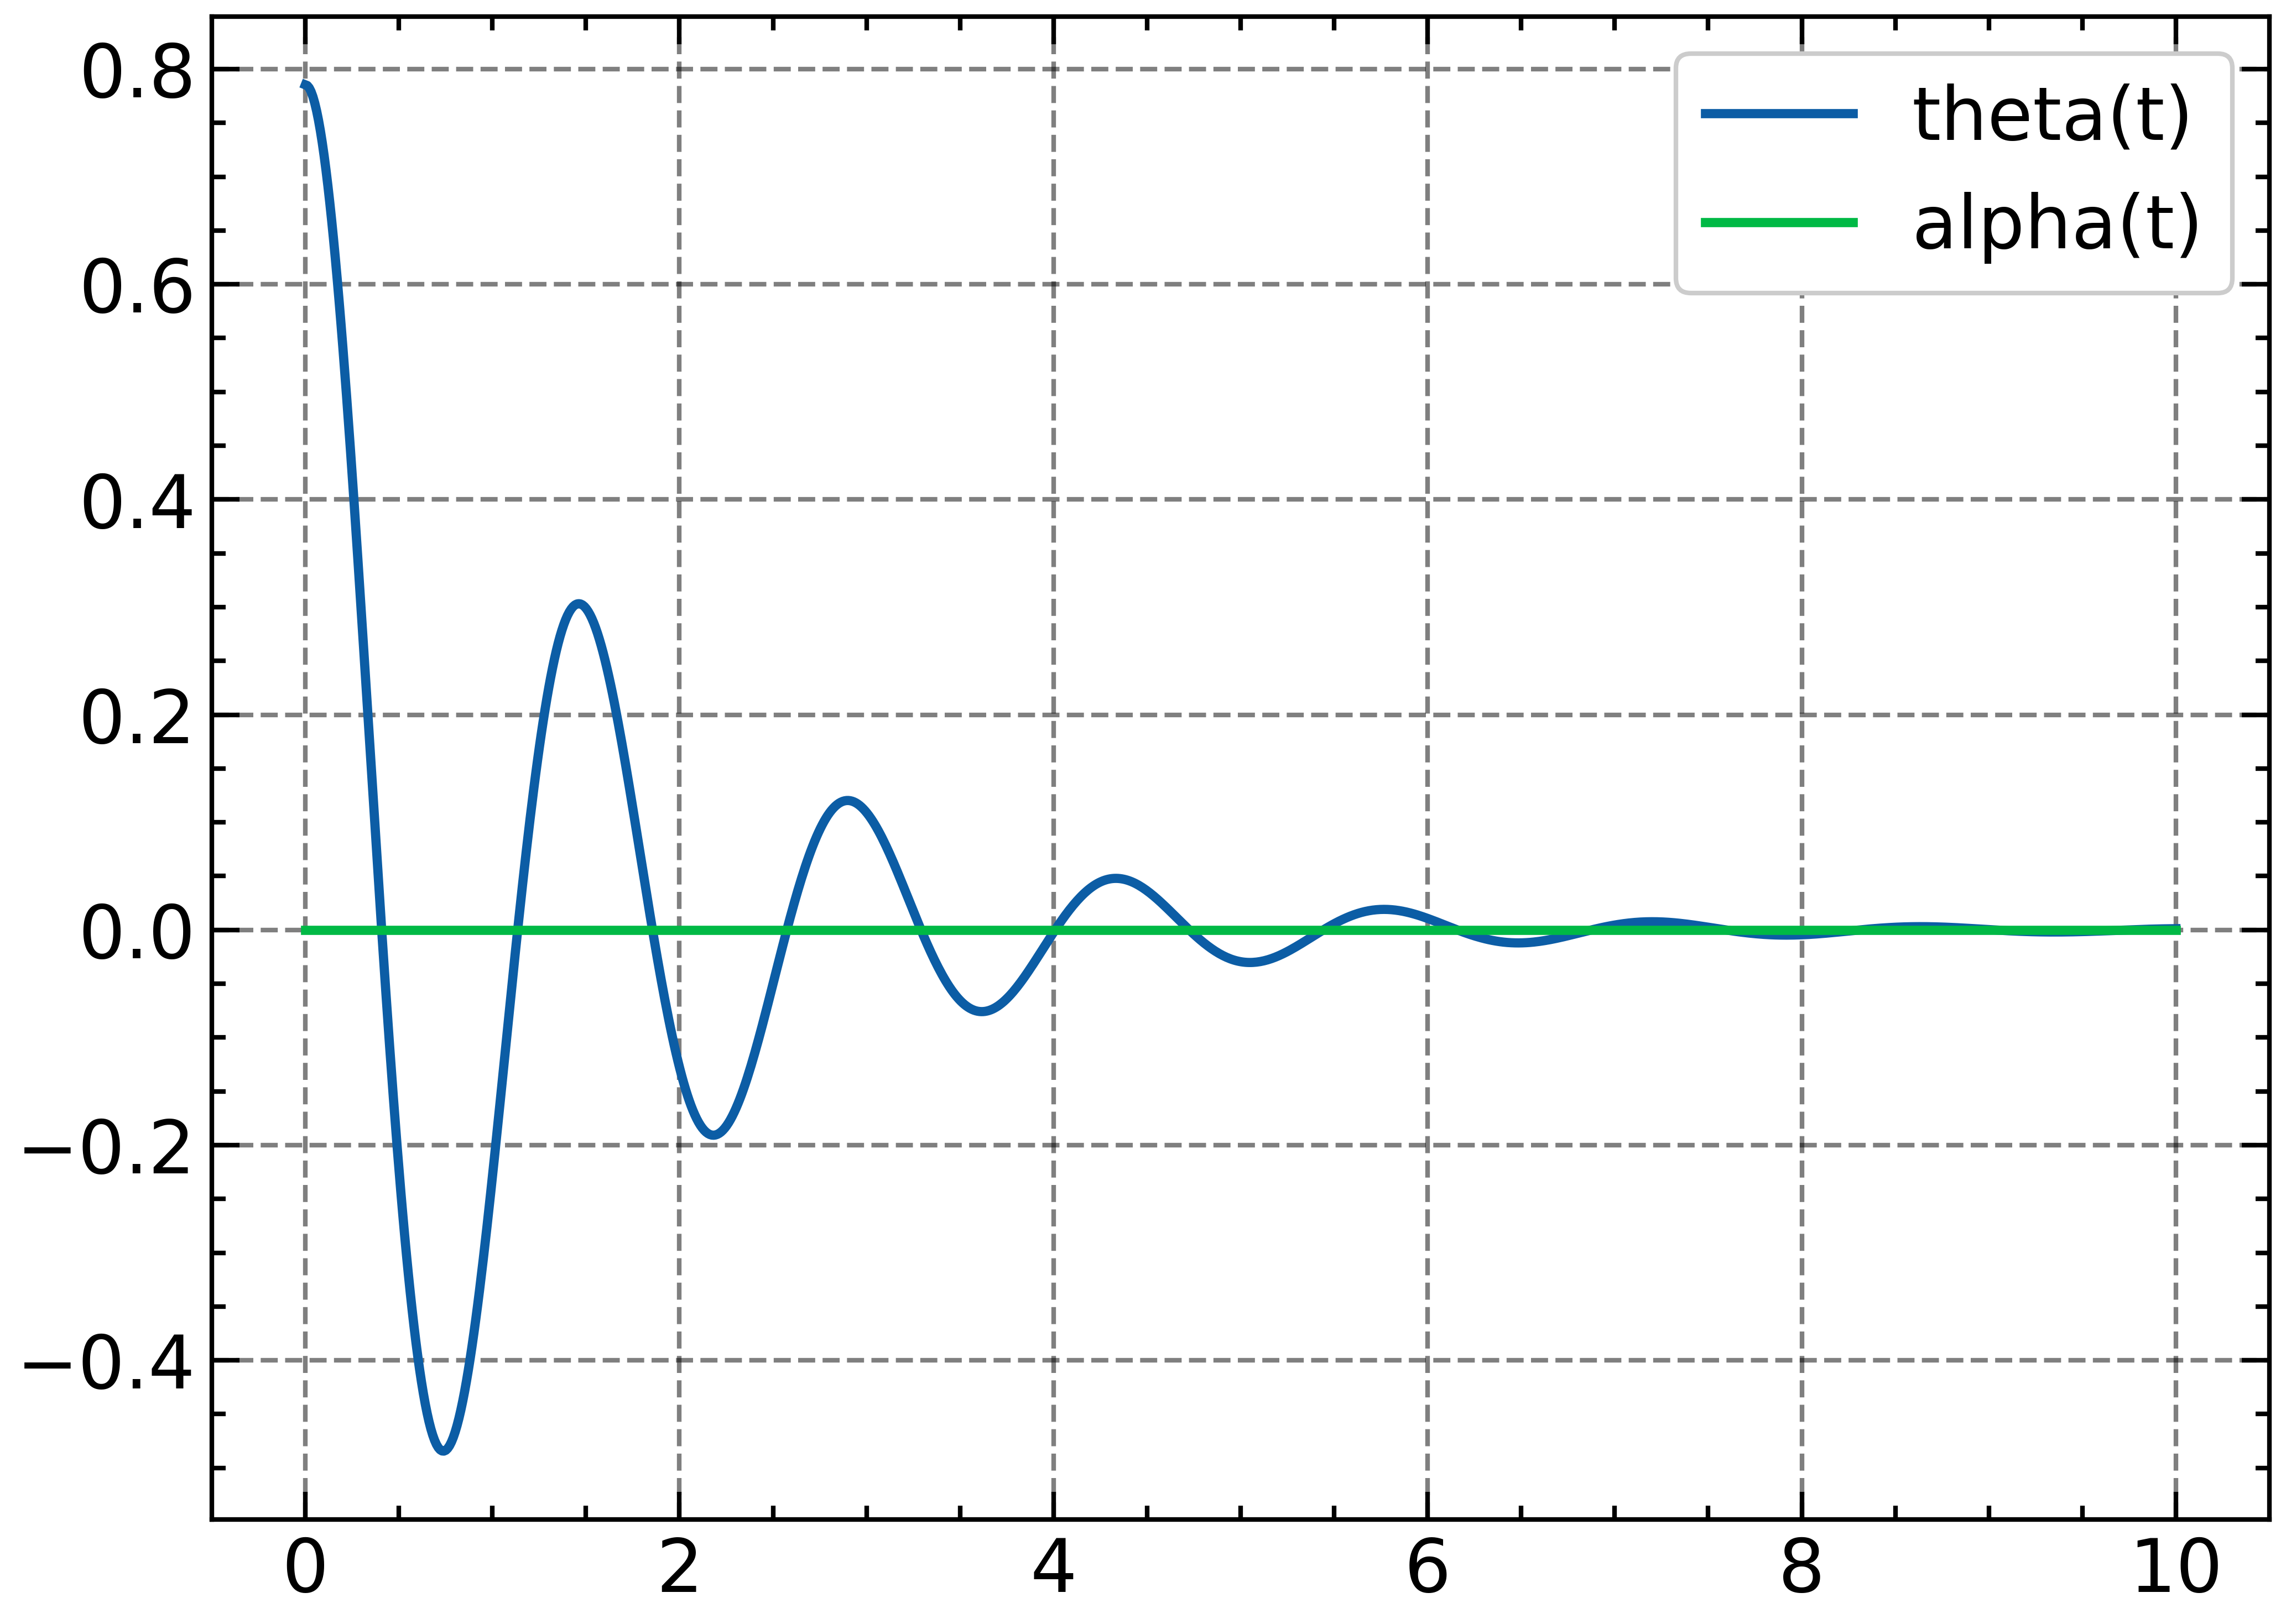

In [294]:
# Numerical solution
# S =  [theta, theta_dot, alpha, alpha_dot]
# dSdt = [d_theta, d2_theta, d_alpha, d2_alpha]


bp = .4
c1 = .32
u1 = 0
jp = 1.84e-4
by = .8
c2 = .32
u2 = 0
l = .5
m = 1.25
jy = 1.83e-4
g = 9.81


def dsdt(_, s):
  _theta, _omega, _, _zeta = s

  return np.array([
    _omega,
    d2_theta_func(bp, _omega, c1, u1, g, l, m, _theta, _zeta, jp),
    _zeta,
    d2_alpha_func(by, _zeta, c2, u2, l, m, _omega, _theta, jy)
  ])


th_0  = np.pi - (np.pi / 4)
omg_0 = 0
alp_0 = 0
zh_0  = 0

S_0 = (th_0, omg_0, alp_0, zh_0)

t_eval = np.linspace(1e-4, 10, 1000)
t_span = [min(t_eval), max(t_eval)]

sol = solve_ivp(dsdt, t_span, y0=S_0, t_eval=t_eval)

plt.plot(sol.t, np.pi - sol.y[0], label='theta(t)')
plt.plot(sol.t, sol.y[2], label='alpha(t)')
plt.legend()

plt.savefig('pendulo.png', dpi=300)